# **Cài đặt các thư viện cần thiết**

In [ ]:
!pip install pandas  matplotlib pyspark
!pip install umap-learn
!pip install umap-learn[plot]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b04f79b24a09fca27567ac95f83075512035905f0900f2f871c96c3052242d5c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 44.4 MB/s eta 0:00:00


## **Cài đặt PySpark**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

## **Import các thư viện cần thiết**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
import umap
import umap.plot
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, OneVsRest, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# **Câu 1: Phân cụm dữ liệu**

In [ ]:
class MNISTClustering:
    def __init__(self, file_path):
        self.file_path = file_path
        self.spark = SparkSession.builder.appName("MNIST Clustering").getOrCreate()
        self.data = None
        self.model = None
        self.predictions = None

    def run(self, weighted_indices):
        self.load_data()
        self.preprocess_data()
        self.apply_weights(weighted_indices)
        self.fit_kmeans()
        distances = self.calculate_distances()
        self.plot_results(distances)
        self.spark.stop()

    def load_data(self):
        schema = ["label"] + [f"pixel_{i}" for i in range(784)]
        self.data = self.spark.read.csv(self.file_path, header=False, inferSchema=True).toDF(*schema)

    def preprocess_data(self):
        assembler = VectorAssembler(
            inputCols=[f"pixel_{i}" for i in range(784)],
            outputCol="features"
        )
        self.data = assembler.transform(self.data)

    def apply_weights(self, weighted_indices):
        self.data = self.data.withColumn("weight", lit(1.0))
        for idx in weighted_indices:
            self.data = self.data.withColumn(
                "weight",
                when(col("label") == idx, col("weight") * 100).otherwise(col("weight"))
            )

    def fit_kmeans(self, k=10):
        kmeans = KMeans(k=k, seed=1, weightCol="weight", featuresCol="features")
        self.model = kmeans.fit(self.data)
        self.predictions = self.model.transform(self.data)

    def calculate_distances(self):
        def squared_distance(point, centroid):
            return float(Vectors.squared_distance(point, centroid))

        centroids = self.model.clusterCenters()
        self.data = self.predictions.rdd.map(lambda row: (row['prediction'], squared_distance(row['features'], centroids[row['prediction']])))
        return self.data.toDF(["prediction", "squared_distance"])

    def plot_results(self, distances):
        average_distances = distances.groupBy("prediction").avg("squared_distance").collect()
        labels = [row["prediction"] for row in average_distances]
        avg_distances = [row["avg(squared_distance)"] for row in average_distances]

        plt.figure(figsize=(10, 6))
        plt.bar(labels, avg_distances)
        plt.xlabel('Cluster')
        plt.ylabel('Average Squared Distance to Centroid')
        plt.title('Average Squared Distance to Centroid for each Cluster')
        plt.show()
        # Plotting UMAP
        features = self.predictions.select("features").rdd.map(lambda row: row[0]).collect()
        features = np.array([list(vector) for vector in features])
        labels = self.predictions.select("label").rdd.map(lambda row: row[0]).collect()
        labels = np.array(labels)

        mapper = umap.UMAP().fit(features)
        umap.plot.points(mapper, labels=labels, theme='fire')


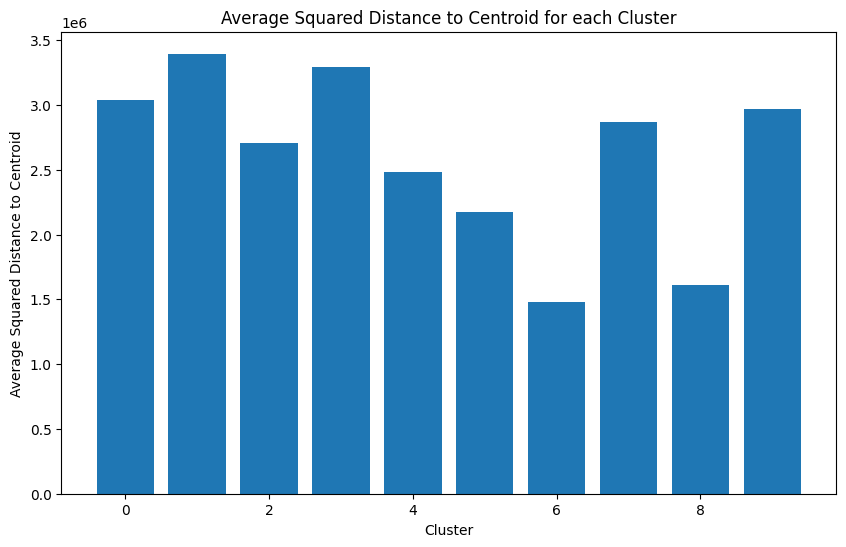

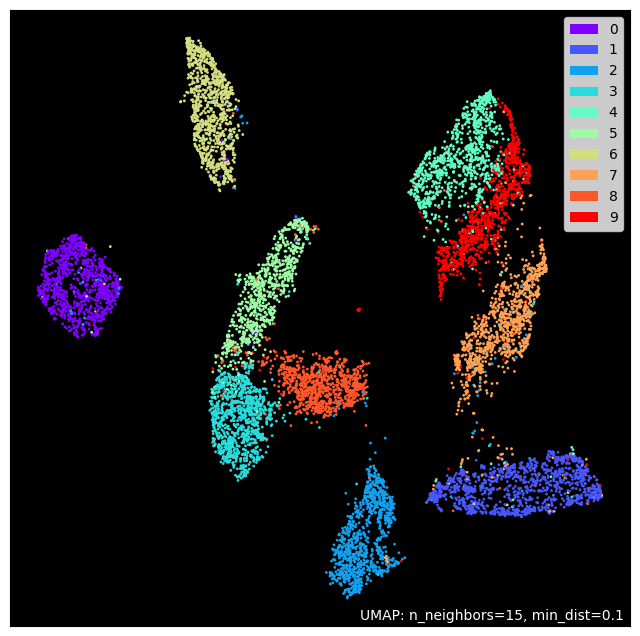

In [ ]:
file_path = "/content/drive/MyDrive/BigData/final/datasets/mnist_mini.csv"
mnist_clustering = MNISTClustering(file_path)
mnist_clustering.run([0, 1, 2, 3, 4, 7, 8, 11, 18, 61])

# **Câu 2: Giảm số chiều với SVD**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class DataProcessor:
    def __init__(self, file_path):
        # Khởi tạo phiên Spark
        self.spark = SparkSession.builder.appName("SVD").getOrCreate()
        self.file_path = file_path
        # Đọc tệp CSV vào DataFrame với tiêu đề và suy luận lược đồ
        self.data_frame = self.spark.read.csv(self.file_path, header=True, inferSchema=True)
        self.feature_columns = self.data_frame.columns[1:]  # Bỏ qua cột đầu tiên nếu nó là cột chỉ mục/ID
        self.vectorized_df = None
        self.scaled_df = None
        self.svd_result = None

    def create_vector(self):
        # Ghép các cột đặc trưng thành một cột vector duy nhất
        assembler = VectorAssembler(inputCols=self.feature_columns, outputCol="features", handleInvalid="skip")
        self.vectorized_df = assembler.transform(self.data_frame).select("features")

    def scale_features(self):
        # Chuẩn hóa các đặc trưng
        scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
        scaler_model = scaler.fit(self.vectorized_df)  # Huấn luyện mô hình scaler
        self.scaled_df = scaler_model.transform(self.vectorized_df)  # Áp dụng scaler vào dữ liệu

    def apply_svd(self, components=3):
        # Chuyển đổi dữ liệu từ Spark DataFrame sang Pandas DataFrame
        features_array = self.scaled_df.select("scaledFeatures").rdd.map(lambda row: row.scaledFeatures.toArray()).collect()
        features_df = pd.DataFrame(features_array)

        # Áp dụng SVD để giảm chiều dữ liệu
        svd = TruncatedSVD(n_components=components)
        svd_features = svd.fit_transform(features_df)
        self.svd_result = pd.DataFrame(svd_features, columns=[f"svd_{i+1}" for i in range(components)])

    def close_session(self):
        # Dừng phiên Spark
        self.spark.stop()

In [ ]:
class ClusterPlotter:
    def __init__(self, svd_data):
        self.svd_data = svd_data  # Dữ liệu đầu vào đã giảm chiều
        self.sample_points = None
        self.cluster_labels = None

    def random_sample(self, sample_size=100):
        # Lấy mẫu ngẫu nhiên các điểm dữ liệu để vẽ biểu đồ
        self.sample_points = self.svd_data.sample(n=sample_size).to_numpy()

    def label_clusters(self, labels):
        # Gán nhãn cụm cho các điểm dữ liệu mẫu
        self.cluster_labels = [int(label[0]) for label in labels]

    def draw_plot(self):
        # Vẽ các điểm dữ liệu được phân cụm trong không gian 3D
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#4B0082', '#FF4500', '#1E90FF', '#DAA520', '#8A2BE2', '#D2691E']
        markers = ['o', '^', 's', 'p', '*', 'h', 'x', 'D', '<', '>']
        for i in range(len(self.sample_points)):
            point = self.sample_points[i]
            cluster = self.cluster_labels[i]
            ax.scatter(point[0], point[1], point[2], c=colors[cluster % len(colors)], marker=markers[cluster % len(markers)])
        ax.set_xlabel('SVD1')
        ax.set_ylabel('SVD2')
        ax.set_zlabel('SVD3')
        plt.title('Phân cụm điểm dữ liệu sau khi giảm số chiều')
        plt.show()

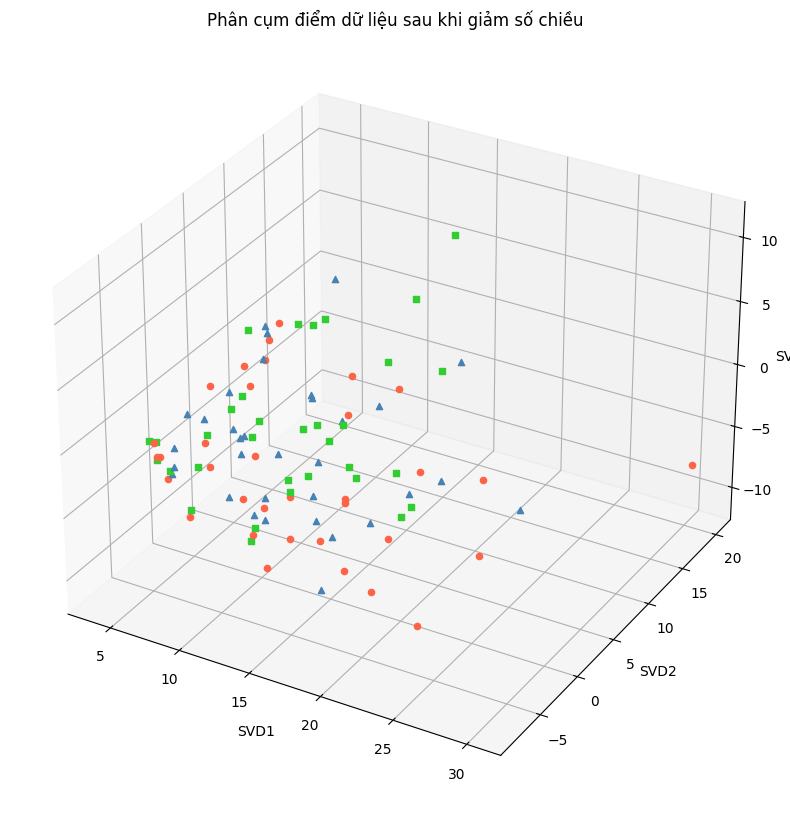

In [ ]:
# Xử lý chính
data_processor = DataProcessor("/content/mnist_mini.csv")  # Khởi tạo DataProcessor với đường dẫn tệp
data_processor.create_vector()  # Biến đổi các đặc trưng thành vector
data_processor.scale_features()  # Chuẩn hóa các đặc trưng
data_processor.apply_svd()  # Áp dụng SVD để giảm chiều dữ liệu

# Gán cụm giả lập minh họa
cluster_assignments = [(i % 3,) for i in range(100)]

plotter = ClusterPlotter(data_processor.svd_result)  # Khởi tạo ClusterPlotter với kết quả SVD
plotter.random_sample()  # Lấy mẫu ngẫu nhiên các điểm dữ liệu sau SVD
plotter.label_clusters(cluster_assignments)  # Gán phãn cụm cho các điểm dữ liệu mẫu
plotter.draw_plot()  # Vẽ biểu đồ các điểm dữ liệu
data_processor.close_session()  # Đóng phiên Spark

# **Câu 3: Khuyến nghị sản phẩm với Collaborative Filtering**

Best Rank: 16, Best RegParam: 0.1, Best MSE: 1.1082456729918457


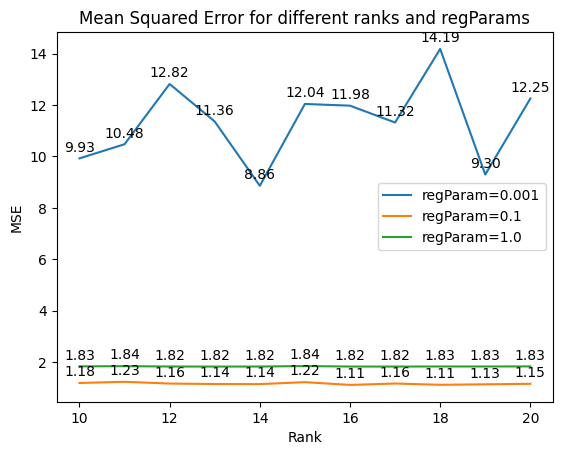

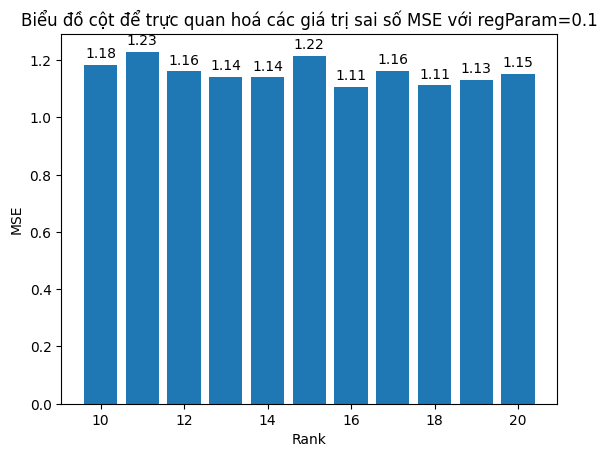

+----+-----------------------------------------------------------------------------------------+
|user|recommendations                                                                          |
+----+-----------------------------------------------------------------------------------------+
|1   |[{352, 4.9957857}, {168, 4.8717413}, {288, 4.331066}, {176, 4.1972656}, {39, 4.1031055}] |
|2   |[{183, 4.8015647}, {67, 4.7577333}, {335, 4.7079678}, {432, 4.6918344}, {251, 4.671492}] |
|3   |[{117, 4.9381385}, {376, 4.929508}, {440, 4.8302565}, {385, 4.8171616}, {301, 4.7906375}]|
|4   |[{440, 3.8884704}, {301, 3.6690052}, {376, 3.6348515}, {163, 3.6135557}, {36, 3.5931165}]|
|5   |[{80, 4.948329}, {36, 4.86577}, {340, 4.840484}, {397, 4.800328}, {34, 4.7937336}]       |
+----+-----------------------------------------------------------------------------------------+
only showing top 5 rows

+----+----------------------------------------------------------------------------------+
|item|recomm

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.functions import collect_list
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LinearSVC  ,OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

class RecommendationSystem:
    def __init__(self, file_path):
        # Khởi tạo instance Spark
        self.spark = SparkSession.builder.appName("ALSExample").getOrCreate()
        self.file_path = file_path
        # Load dữ liệu từ file CSV
        self.ratings = self.load_data()
        # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
        self.train_data, self.test_data = self.split_data()
        # Khởi tạo một đối tượng RegressionEvaluator để đánh giá mô hình
        self.evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")

    def load_data(self):
        # Đọc dữ liệu từ file CSV
        lines = self.spark.read.csv(self.file_path, header=True, inferSchema=True).rdd
        # Chuyển đổi các dòng dữ liệu thành các đối tượng Row với các cột user, item, rating
        ratings = lines.map(lambda row: Row(user=int(row[1]), item=int(row[2]), rating=float(row[3])))
        # Tạo DataFrame từ các đối tượng Row
        return self.spark.createDataFrame(ratings)

    def split_data(self):
        # Chia dữ liệu thành 70% tập huấn luyện và 30% tập kiểm tra với seed fit
        return self.ratings.randomSplit([0.7, 0.3], seed=1234)

    def train_model(self, rank, regParam):
        # Khởi tạo mô hình ALS với các tham số cụ thể
        als = ALS(
            maxIter=10,
            regParam=regParam,
            userCol="user",
            itemCol="item",
            ratingCol="rating",
            coldStartStrategy="drop",
            rank=rank)
        # Huấn luyện mô hình trên tập huấn luyện
        model = als.fit(self.train_data)
        # Dự đoán trên tập kiểm tra
        predictions = model.transform(self.test_data)
        # Tính toán MSE trên tập kiểm tra
        mse = self.evaluator.evaluate(predictions)
        return mse

    def evaluate_model(self):
        # Danh sách các giá trị rank để thử nghiệm
        ranks = list(range(10, 21))
        # Danh sách các giá trị regParam để thử nghiệm
        regParams = [0.001, 0.1, 1.0]
        # Kết quả lưu trữ các cặp (regParam, danh sách (rank, mse))
        results = []

        # Biến để theo dõi giá trị MSE tốt nhất và các tham số tương ứng
        best_mse = float('inf')
        best_rank = -1
        best_regParam = -1

        # Thử nghiệm tất cả các cặp (rank, regParam)
        for regParam in regParams:
            mse_list = []
            for rank in ranks:
                # Huấn luyện mô hình và tính toán MSE
                mse = self.train_model(rank, regParam)
                mse_list.append((rank, mse))
                # Cập nhật giá trị MSE tốt nhất và các tham số tương ứng
                if mse < best_mse:
                    best_mse = mse
                    best_rank = rank
                    best_regParam = regParam
            results.append((regParam, mse_list))

        # In ra các giá trị tốt nhất
        print(f"Best Rank: {best_rank}, Best RegParam: {best_regParam}, Best MSE: {best_mse}")
        return results, best_rank, best_regParam

    def plot_best_regparam(self, results, best_regParam):
        # Tìm danh sách MSE cho regParam tốt nhất
        for regParam, mse_list in results:
            if regParam == best_regParam:
                ranks = [x[0] for x in mse_list]
                mses = [x[1] for x in mse_list]
                # Vẽ biểu đồ cột cho các giá trị MSE
                plt.bar(ranks, mses)
                for rank, mse in mse_list:
                    # Thêm giá trị MSE lên trên mỗi cột
                    plt.annotate(f'{mse:.2f}', (rank, mse), textcoords="offset points", xytext=(0,5), ha='center')

        plt.xlabel('Rank')
        plt.ylabel('MSE')
        plt.title(f'Biểu đồ cột để trực quan hoá các giá trị sai số MSE với regParam={best_regParam}')
        plt.show()

    def plot_results(self, results):
        # Vẽ biểu đồ đường cho mỗi giá trị regParam
        for regParam, mse_list in results:
            ranks = [x[0] for x in mse_list]
            mses = [x[1] for x in mse_list]
            plt.plot(ranks, mses, label=f'regParam={regParam}')
            for rank, mse in mse_list:
                # Thêm giá trị MSE trên biểu đồ đường
                plt.annotate(f'{mse:.2f}', (rank, mse), textcoords="offset points", xytext=(0,5), ha='center')

        plt.xlabel('Rank')
        plt.ylabel('MSE')
        plt.title('Mean Squared Error for different ranks and regParams')
        plt.legend()
        plt.show()

    def run_inference(self, best_rank, best_regParam):
        # Khởi tạo mô hình ALS với các tham số tốt nhất
        als = ALS(
            maxIter=10,
            regParam=best_regParam,
            userCol="user",
            itemCol="item",
            ratingCol="rating",
            coldStartStrategy="drop",
            rank=best_rank
        )

        # Huấn luyện mô hình trên tập huấn luyện
        model = als.fit(self.train_data)
        # Đưa ra gợi ý cho mỗi người dùng:
        user_recs = model.recommendForAllUsers(5)
        # Sắp xếp và hiển thị kết quả gợi ý cho người dùng
        user_recs.sort("user", ascending=True).show(5, truncate=False)
        # Đưa ra gợi ý cho mỗi mặt hàng:
        item_recs = model.recommendForAllItems(5)
        # Sắp xếp và hiển thị kết quả gợi ý cho mặt hàng
        item_recs.sort("item", ascending=True).show(5, truncate=False)

    def run(self):
        # Đánh giá mô hình để tìm các tham số tốt nhất
        results, best_rank, best_regParam = self.evaluate_model()
        # Vẽ biểu đồ kết quả đánh giá
        self.plot_results(results)
        # Vẽ biểu đồ cột cho regParam tốt nhất
        self.plot_best_regparam(results, best_regParam)
        # Chạy suy luận với các tham số tốt nhất
        self.run_inference(best_rank, best_regParam)

if __name__ == "__main__":
    # Đường dẫn đến file CSV chứa dữ liệu
    file_path = "/content/ratings2k.csv"
    # Khởi tạo và chạy hệ thống gợi ý
    recommender = RecommendationSystem(file_path)
    recommender.run()

# **Câu 4: Dự đoán giá chứng khoán**


**Import Library**

In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.regression import LinearRegression

sc = SparkContext.getOrCreate('local')
spark = SQLContext(sc)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, udf, array, to_date, when
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
import numpy as np
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

In [ ]:
class StockHVNPredicion:

  def __init__(self, path):
    # Khởi tạo Spark session
    self.spark = SparkSession.builder.appName("StockHVNPrediction").getOrCreate()

    # Đọc dữ liệu từ file CSV
    self.data = self.spark.read.csv(path, header=True, inferSchema=True)

    self.df = self.data.withColumn('Ngay', to_date(col('Ngay'), "dd/MM/yyyy"))


  def separate_data(self):
    self.train_data = self.df.filter(col("Ngay") < "2022-07-01")
    # print("train")
    # self.train_data.show()
    self.test_data = self.df.filter(col("Ngay") >= "2022-07-01")
    # print("test")
    # self.test_data.show()

  def data_prepare(self):
    #Create new column include previous day's price
    wSpec = Window.orderBy("Ngay")
    self.df = self.df.withColumn("Previous HVN", lag("HVN").over(wSpec))
    self.df = self.df.withColumn("Fluctuation", when(col("Previous HVN").isNull(), 0) \
            .otherwise(col('HVN') - col("Previous HVN")) / col("Previous HVN"))
    #self.df.show()
    # Create new Column include the fluctuation 5 days before
    input_cols = [f"Fluatuation_Lag_{i}" for i in range(1, 6)]
    for i in range(1, 6):
        self.df = self.df.withColumn(f"Fluatuation_Lag_{i}", lag("Fluctuation", i) \
                                     .over(wSpec)).na.fill(0)

    # Chuyển đổi các cột cần thiết thành định dạng Vector cho mô hình học máy
    assembler = VectorAssembler(inputCols=input_cols, outputCol="Price_Of_5_Days_Before")
    self.df = assembler.transform(self.df) \
              .select("Price_Of_5_Days_Before", "Fluctuation")
    # self.df.show()

  def training_LinearRegression(self):
    linear = LinearRegression(featuresCol='Price_Of_5_Days_Before', labelCol='Fluctuation')
    self.lr_model = linear.fit(self.train_data)

  def evaluate_model(self):
        # Tính toán MSE trên tập train
        train_predictions = self.lr_model.transform(self.train_data)
        train_evaluator = RegressionEvaluator(labelCol="Fluctuation", predictionCol="prediction", metricName="mse")
        self.train_mse = train_evaluator.evaluate(train_predictions)
        print(f"Mean Squared Error (MSE) on train data: {self.train_mse:.5f}")

        # Tính toán MSE trên tập test
        test_predictions = self.lr_model.transform(self.test_data)
        test_evaluator = RegressionEvaluator(labelCol="Fluctuation", predictionCol="prediction", metricName="mse")
        self.test_mse = test_evaluator.evaluate(test_predictions)
        print(f"Mean Squared Error (MSE) on test data: {self.test_mse:.5f}")

  def plot_mse(self):
        # Vẽ biểu đồ cột thể hiện giá trị MSE của hai tập train và test
        mse_values = [self.train_mse, self.test_mse]
        labels = ['Train MSE', 'Test MSE']

        plt.figure(figsize=(10, 6))
        plt.bar(labels, mse_values, color=['blue', 'orange'])
        plt.xlabel('Dataset')
        plt.ylabel('Mean Squared Error')
        plt.title('MSE on Train and Test Data')
        plt.show()

Mean Squared Error (MSE) on train data: 0.00057
Mean Squared Error (MSE) on test data: 0.00065


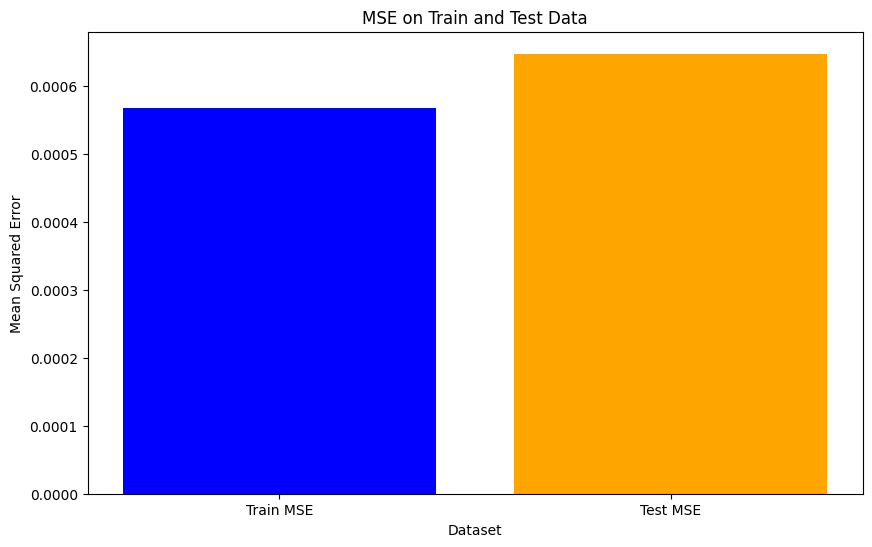

In [ ]:
if __name__ == "__main__":
    predictor = StockHVNPredicion("/content/drive/MyDrive/MMDS/stockHVN2022.csv")
    predictor.data_prepare()
    predictor.separate_data()
    predictor.training_LinearRegression()
    predictor.evaluate_model()
    predictor.plot_mse()

# **Câu 5: Phân loại đa lớp với pyspark**

---



## Thiết lập môi trường và tải dữ liệu

In [ ]:
# Tạo SparkSession
spark = SparkSession.builder.appName("MNIST Classification").getOrCreate()

# Tải dữ liệu
schema = ["label"] + [f"pixel_{i}" for i in range(784)]
data = spark.read.csv(file_path, header=False, inferSchema=True).toDF(*schema)

# Kiểm tra và xử lý giá trị null hoặc NaN
data = data.dropna()
data = data.filter(~data.label.isNull())

# Chuẩn bị dữ liệu

In [ ]:
# Tạo cột features từ các cột pixel
assembler = VectorAssembler(inputCols=[f"pixel_{i}" for i in range(784)], outputCol="features")
data = assembler.transform(data).select("features", "label")

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(train_data)
train_data = scaler_model.transform(train_data)
test_data = scaler_model.transform(test_data)

# Định nghĩa các mô hình phân loại

Multi-layer Perceptron

In [ ]:
# Định nghĩa các lớp của MLP
layers = [784, 128, 64, 10]

mlp = MultilayerPerceptronClassifier(layers=layers, labelCol="label", featuresCol="scaledFeatures", seed=42)

Random Forest

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures", numTrees=100, seed=42)

Linear Support Vector Machine

In [ ]:
svm = LinearSVC(labelCol="label", featuresCol="scaledFeatures", maxIter=50, regParam=0.01)
ovr = OneVsRest(classifier=svm)

## Huấn luyện và đánh giá các mô hình

Hàm để huấn luyện và đánh giá mô hình


In [ ]:
def train_and_evaluate(model, train_data, test_data):
    model = model.fit(train_data)
    train_predictions = model.transform(train_data)
    test_predictions = model.transform(test_data)

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    train_accuracy = evaluator.evaluate(train_predictions)
    test_accuracy = evaluator.evaluate(test_predictions)

    return train_accuracy, test_accuracy


Huấn luyện và đánh giá các mô hình

In [ ]:
# MLP
mlp_train_accuracy, mlp_test_accuracy = train_and_evaluate(mlp, train_data, test_data)
print(f"MLP Train Accuracy: {mlp_train_accuracy}")
print(f"MLP Test Accuracy: {mlp_test_accuracy}")

# Random Forest
rf_train_accuracy, rf_test_accuracy = train_and_evaluate(rf, train_data, test_data)
print(f"Random Forest Train Accuracy: {rf_train_accuracy}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy}")

# Linear SVM sử dụng One-vs-Rest
try:
    svm_train_accuracy, svm_test_accuracy = train_and_evaluate(ovr, train_data, test_data)
    print(f"Linear SVM Train Accuracy: {svm_train_accuracy}")
    print(f"Linear SVM Test Accuracy: {svm_test_accuracy}")
except Exception as e:
    svm_train_accuracy, svm_test_accuracy = 0, 0
    print(f"Error training Linear SVM: {e}")

# Lưu trữ kết quả
results = {
    "Model": ["MLP", "Random Forest", "Linear SVM"],
    "Train Accuracy": [mlp_train_accuracy, rf_train_accuracy, svm_train_accuracy],
    "Test Accuracy": [mlp_test_accuracy, rf_test_accuracy, svm_test_accuracy]
}

MLP Train Accuracy: 1.0
MLP Test Accuracy: 0.939269171384457
Random Forest Train Accuracy: 0.8738984733771875
Random Forest Test Accuracy: 0.8656716417910447
Linear SVM Train Accuracy: 0.9379421620950726
Linear SVM Test Accuracy: 0.9109624292331446


## Trực quan hóa kết quả

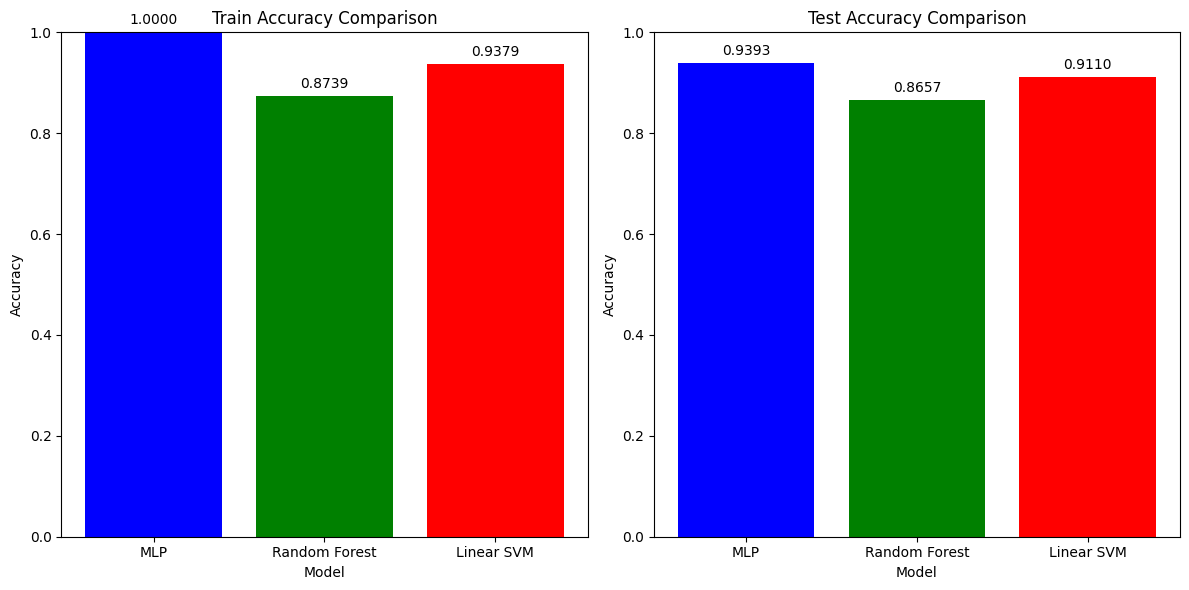

In [ ]:
# Vẽ biểu đồ so sánh độ chính xác trên tập huấn luyện và kiểm tra
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ cho độ chính xác trên tập huấn luyện
plt.subplot(1, 2, 1)
plt.bar(results["Model"], results["Train Accuracy"], color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Train Accuracy Comparison')
plt.ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1
for i, v in enumerate(results["Train Accuracy"]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')

# Vẽ biểu đồ cho độ chính xác trên tập kiểm tra
plt.subplot(1, 2, 2)
plt.bar(results["Model"], results["Test Accuracy"], color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1
for i, v in enumerate(results["Test Accuracy"]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

Kết thúc SparkSession


In [ ]:
spark.stop()